# Load the Configuration of YOLOs

<img src="https://colab.research.google.com/img/colab_favicon_256px.png" alt="Running on Colab" width='60'> [Runing on colab]()

**1. Importing the ultralytics framework** :

imports the YOLO backbone from the ultralytics library. This library provides tools for working with the YOLO (You Only Look Once) family of computer vision models.

**2. Loading pre-trained model**:

creates an instance of the YOLO class and loads a pre-trained model named yolov8n-pose.pt. This model is specifically designed for keypoints estimation tasks.

**Options**: [[YOLOv8-pose]](https://docs.ultralytics.com/models/yolov8/) | [[YOLO11-pose]](https://docs.ultralytics.com/models/yolo11/)

In [2]:
!pip install ultralytics
from ultralytics import YOLO

model_name = "yolov8n-pose.pt"   # @param ["yolov8n-pose.pt", "yolov8s-pose.pt", "yolov8m-pose.pt", "yolov8l-pose.pt", "yolov8x-pose.pt", "yolov8x-pose-p6.pt"]
model = YOLO(model_name)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.0/887.0 kB 14.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.52M/6.52M [00:00<00:00, 79.4MB/s]


# Delegation

## HailoRT

**Step1.** Export to ONNX format with opset 11.

In [3]:
model.export(format='onnx', imgsz=640, opset=11)

Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-pose summary (fused): 187 layers, 3,289,964 parameters, 0 gradients, 9.2 GFLOPs

PyTorch: starting from 'yolov8n-pose.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 56, 8400) (6.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 163.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 151.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 184.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 14.6s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect




'yolov8n-pose.onnx'

**Step2.** Validate the accuracy

In [27]:
delegated_model = YOLO('./yolov8n-pose.onnx')
metrics = delegated_model.val(data="coco8-pose.yaml")

print(metrics.box.map)  # mAP50-95
print(metrics.box.map50)
print(metrics.pose.map)  # mAP50-95
print(metrics.pose.map50)

0.7508437068003383
0.9293362831858406
0.39309694566278164
0.7143203636363634


**Step3.** Reproduce the output process manually.

In [ ]:
import numpy as np

class YOLOv8Pose():
    def __init__(self, model_path, nc = 1, num_of_keypoints = 17):
        self.session = ort.InferenceSession(model_path)
        self.input_details  = [i for i in self.session.get_inputs()]
        self.output_details = [i.name for i in self.session.get_outputs()]
        self.X_axis = [0, 2] + [5 + i * 3 for i in range(num_of_keypoints)]
        self.y_axis = [1, 3] + [6 + i * 3 for i in range(num_of_keypoints)]
        self.nc = nc

    def predict(self, frames, conf=0.25, iou=0.7, agnostic=False, max_det=300):
        im = self.preprocess(frames)
        preds = self.inference(im)
        results = self.postprocess(preds, conf_thres=conf, iou_thres=iou, agnostic=agnostic, max_det=max_det)
        return results

    def postprocess(self, preds, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False, labels=(), max_det=300, nc=0, max_time_img=0.05, max_nms=30000, max_wh=7680, in_place=True, rotated=False):
        xc = np.max(preds[:, 4: self.nc + 4], axis = 1) > conf_thres
        preds = np.transpose(preds, (0, 2, 1))
        preds[..., :4] = xywh2xyxy(preds[..., :4])
        x = preds[0][xc[0]]

        if not x.shape[0]:
          return None
        box, cls, keypoints = x[:, :4], x[:, 4:5], x[:, 5:]
        j = np.argmax(cls, axis=1)
        conf = cls[[i for i in range(len(j))], j]
        concatenated = np.concatenate((box, conf.reshape(-1, 1), j.reshape(-1, 1).astype(float), keypoints), axis=1)
        x = concatenated[conf.flatten() > conf_thres]

        if x.shape[0] > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]
        cls = x[:, 5:6] * (0 if agnostic else max_wh)
        scores, boxes = x[:, 4], x[:, :4] + cls

        i = non_max_suppression(boxes, scores, iou_thres)
        return [x[i[:max_det]]]

    def inference(self, im):
        inputs = {key.name: value for key, value in zip(self.input_details, [im])}
        preds = self.session.run(self.output_details, inputs)[0]
        return preds

    def preprocess(self, im):
        im = np.stack(self.pre_transform(im))
        im = im[..., ::-1]
        im = np.ascontiguousarray(im).astype(np.float32)
        im /= 255.0
        im = np.transpose(im, (0, 3, 1, 2))
        return im

    def pre_transform(self, im):
        imgsz = self.input_details[0].shape[2:4]
        return [cv2.resize(im[0], imgsz, interpolation=cv2.INTER_LINEAR) for x in im]

class LetterBox:
    def __init__(self, new_shape=(640, 640), auto=False, scaleFill=False, scaleup=True, center=True, stride=32):
        self.new_shape = new_shape
        self.auto = auto
        self.scaleFill = scaleFill
        self.scaleup = scaleup
        self.stride = stride
        self.center = center

    def __call__(self, labels=None, image=None):
        if labels is None:
            labels = {}
        img = labels.get("img") if image is None else image
        shape = img.shape[:2]
        new_shape = labels.pop("rect_shape", self.new_shape)
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not self.scaleup:
            r = min(r, 1.0)

        ratio = r, r
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if self.auto:
            dw, dh = np.mod(dw, self.stride), np.mod(dh, self.stride)  # wh padding
        elif self.scaleFill:
            dw, dh = 0.0, 0.0
            new_unpad = (new_shape[1], new_shape[0])
            ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

        if self.center:
            dw /= 2
            dh /= 2

        if shape[::-1] != new_unpad:
            img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)) if self.center else 0, int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)) if self.center else 0, int(round(dw + 0.1))
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))
        if labels.get("ratio_pad"):
            labels["ratio_pad"] = (labels["ratio_pad"], (left, top))  # for evaluation

        if len(labels):
            labels = self._update_labels(labels, ratio, dw, dh)
            labels["img"] = img
            labels["resized_shape"] = new_shape
            return labels
        else:
            return img

    def _update_labels(self, labels, ratio, padw, padh):
        labels["instances"].convert_bbox(format="xyxy")
        labels["instances"].denormalize(*labels["img"].shape[:2][::-1])
        labels["instances"].scale(*ratio)
        labels["instances"].add_padding(padw, padh)
        return labels

def xywh2xyxy(x):
    assert x.shape[-1] == 4, f"input shape last dimension expected 4 but input shape is {x.shape}"
    y = np.empty_like(x)
    xy = x[..., :2]
    wh = x[..., 2:] / 2
    y[..., :2] = xy - wh
    y[..., 2:] = xy + wh
    return y

def non_max_suppression(boxes, scores, iou_threshold):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]

    return np.array(keep)

def plot(image, results, connections, visible = 0.1):
    for bboxes in results:
      x1, y1, x2, y2 = int(bboxes[0] * image.shape[1] / 640), int(bboxes[1] * image.shape[0] / 640), int(bboxes[2] * image.shape[1] / 640), int(bboxes[3] * image.shape[0] / 640)
      conf, cls = bboxes[4] , bboxes[5]
      cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=3)
      cv2.putText(image, f'instance {conf:.2f}', (x1, y1 - 2), 0, 1, [0, 255, 0], thickness=2, lineType=cv2.LINE_AA)

      keypoints = bboxes[6:].reshape(-1, 3)
      keypoints[:, 0] *=  image.shape[1] / 640
      keypoints[:, 1] *=  image.shape[0] / 640
      for i in range(len(keypoints)):
        if keypoints[i][2] > visible:
          cv2.circle(image, (int(keypoints[i][0]), int(keypoints[i][1])), 5, (0, 255, 0), -1)

      for connection in connections:
        start_idx, end_idx = connection
        if start_idx < len(keypoints) and end_idx < len(keypoints):
          if keypoints[start_idx][2] > visible and keypoints[end_idx][2] > visible:
            cv2.line(image, (int(keypoints[start_idx][0]), int(keypoints[start_idx][1])), (int(keypoints[end_idx][0]), int(keypoints[end_idx][1])), (0, 255, 0), 2)
    return image

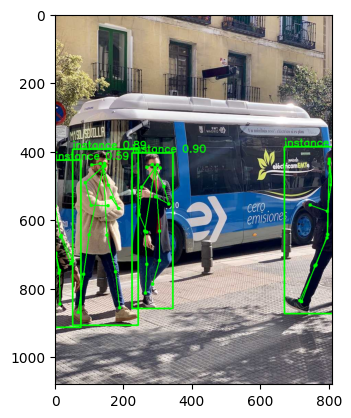

In [ ]:
!wget https://ultralytics.com/images/bus.jpg -O bus.jpg
import onnxruntime as ort

connections = [(4, 2), (2, 0), (3, 1), (1, 0), (0, 6), (6, 8), (8, 10),
         (0, 5), (5, 7), (7, 9), (0, 12), (12, 14), (14, 16), (0, 11), (11, 13), (13, 15)]

img = cv2.imread('./bus.jpg')
onnx_model = YOLOv8Pose(model_path='./yolov8n-pose.onnx', num_of_keypoints = 17)
results = onnx_model.predict([img])
plt.imshow(plot(img.copy(), results[0].copy(), connections)[:, :, ::-1])
plt.show()

## Export to Others

**Step1.** Export to TFLite format.

In [28]:
model.export(format='tflite', imgsz=640)

Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-pose summary (fused): 187 layers, 3,289,964 parameters, 0 gradients, 9.2 GFLOPs

PyTorch: starting from 'yolov8n-pose.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 56, 8400) (6.5 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx2tf>1.17.5,<=1.22.3', 'tflite_support'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 204.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 186.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 178.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 182.7 M

100%|██████████| 1.11M/1.11M [00:00<00:00, 20.6MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 39.13file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.39...
ONNX: export success ✅ 2.0s, saved as 'yolov8n-pose.onnx' (13.0 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 34.7s, saved as 'yolov8n-pose_saved_model' (32.5 MB)

TensorFlow Lite: starting export with tensorflow 2.17.1...
TensorFlow Lite: export success ✅ 0.0s, saved as 'yolov8n-pose_saved_model/yolov8n-pose_float32.tflite' (12.9 MB)

Export complete (35.8s)
Results saved to /content
Predict:         yolo predict task=pose model=yolov8n-pose_saved_model/yolov8n-pose_float32.tflite imgsz=640  
Validate:        yolo val task=pose model=yolov8n-pose_saved_model/yolov8n-pose_float32.tflite imgsz=640 data=/usr/src/app/ultralytics/datasets/coco-pose.yaml  
Visualize:       https://netron.app


'yolov8n-pose_saved_model/yolov8n-pose_float32.tflite'

In [29]:
delegated_model = YOLO('./yolov8n-pose_saved_model/yolov8n-pose_float32.tflite')
metrics = delegated_model.val(data="coco8-pose.yaml")

print(metrics.box.map)  # mAP50-95
print(metrics.box.map50)
print(metrics.pose.map)  # mAP50-95
print(metrics.pose.map50)

Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Loading yolov8n-pose_saved_model/yolov8n-pose_float32.tflite for TensorFlow Lite inference...
Setting batch=1 input of shape (1, 3, 640, 640)


val: Scanning /content/datasets/coco8-pose/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


                   all          4         14      0.966      0.929      0.929      0.751      0.895      0.714      0.714      0.393
Speed: 2.3ms preprocess, 244.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/pose/val5
0.7508437068003383
0.9293362831858406
0.39309694566278164
0.7143203636363634


In [30]:
delegated_model = YOLO('./yolov8n-pose_saved_model/yolov8n-pose_float16.tflite')
metrics = delegated_model.val(data="coco8-pose.yaml")

print(metrics.box.map)  # mAP50-95
print(metrics.box.map50)
print(metrics.pose.map)  # mAP50-95
print(metrics.pose.map50)

Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Loading yolov8n-pose_saved_model/yolov8n-pose_float16.tflite for TensorFlow Lite inference...
Setting batch=1 input of shape (1, 3, 640, 640)


val: Scanning /content/datasets/coco8-pose/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


                   all          4         14      0.966      0.929      0.929      0.751      0.896      0.714      0.714      0.393
Speed: 8.1ms preprocess, 445.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/pose/val6
0.7507890127790524
0.9292608695652174
0.3930292911388128
0.7142529644268774
